# Description:

    Check global patterns with rarefied dataset to determine if batch effects are primarily a result of sequencing depth
    
    Things to try:
        Identify OTUs driving differences among library clusters
        Try correspondance analysis biplot 
        Deseq between batches to identify OTUs
        Is it rare vs abundant taxa that are driving the differences
        
        



# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [7]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 68K
lrwxrwxrwx 1 bryan bryan  130 Nov 19 09:59 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Nov 19 09:59 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 7.4K Nov 10 06:58 NMDS_full_wunif.pdf
-rw-rw-r-- 1 bryan bryan 7.9K Nov  9 13:18 NMDS_plant_wunif.pdf
-rw-rw-r-- 1 bryan bryan 9.7K Sep 29 18:03 NMDS_DAPfacet.pdf
-rw-rw-r-- 1 bryan bryan 8.0K Aug 11 19:58 facet_NMDS_w-enz.pdf
-rw-rw-r-- 1 bryan bryan  22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [8]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [9]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


## Normalize samples and filter out taxa that are less than 3seq in 3 samples 

In [11]:
%%R 
# filtering/normalizing
physeq.p = prune_samples(sampleSums(physeq) >= 10, physeq)

set.seed(611)
phy = rarefy_even_depth(physeq.p)

PassFilter = 
filter_taxa(phy, 
             function(x) sum(x > 3) > 3, TRUE) %>%
                 taxa_names()

physeq.snorm = transform_sample_counts(phy, function(x) x/sum(x))

physeq.snorm = prune_taxa(PassFilter, physeq.snorm)  
    


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1371OTUs were removed because they are no longer 
present in any sample after random subsampling


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [15]:
%%R
sample_sums(phy)%>% range

[1] 5063 5063


## Calculate pairwise weighted Unifrac distances between samples

In [16]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1433597 
Run 1 stress 0.1772546 
Run 2 stress 0.1551008 
Run 3 stress 0.1438151 
... procrustes: rmse 0.009732589  max resid 0.1483431 
Run 4 stress 0.1442172 
Run 5 stress 0.1438795 
Run 6 stress 0.1698713 
Run 7 stress 0.1868974 
Run 8 stress 0.1611953 
Run 9 stress 0.2021966 
Run 10 stress 0.1968576 
Run 11 stress 0.1601153 
Run 12 stress 0.153812 
Run 13 stress 0.1438735 
Run 14 stress 0.1570371 
Run 15 stress 0.1455733 
Run 16 stress 0.1446478 
Run 17 stress 0.1894257 
Run 18 stress 0.14314 
... New best solution
... procrustes: rmse 0.007255031  max resid 0.1070464 
Run 19 stress 0.1848503 
Run 20 stress 0.1580776 


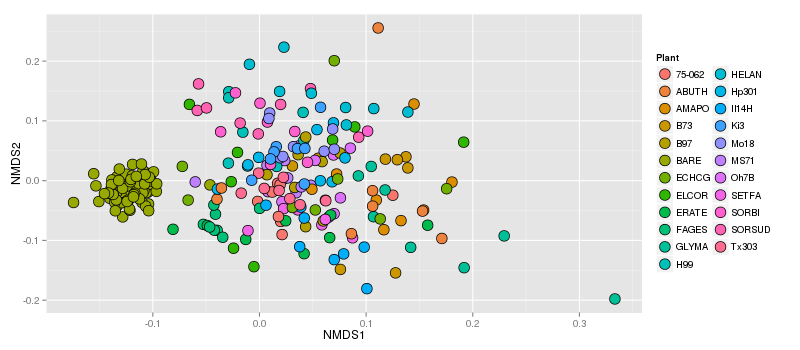

In [17]:
%%R -w 800 -h 350

nmds = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.snorm, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21, size = 5) +
        guides(fill=guide_legend(ncol=2))
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

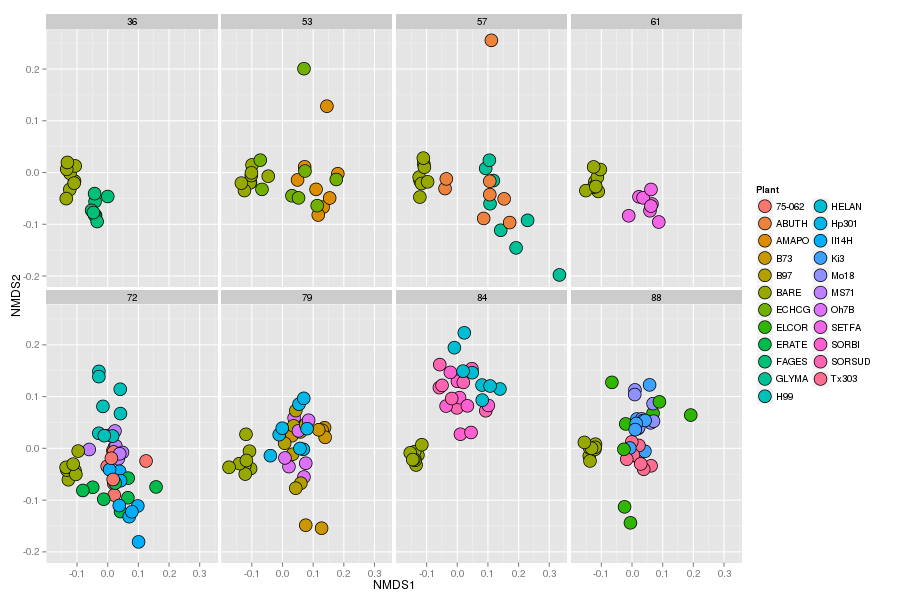

In [18]:
%%R -w 900 -h 600


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP, nrow = 2) +
        guides(fill=guide_legend(ncol=2))
        

p1 

## Subset just bare soils to analyze change with time

In [19]:
%%R

bare = subset_samples(physeq.snorm, Plant == "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)


In [20]:
%%R
registerDoParallel(cores=28)
bare.wunif.dist = distance(bare, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [27]:
%%R
registerDoParallel(cores=28)
bare.bray.dist = distance(bare, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [21]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = bare.wunif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1656417 
Run 1 stress 0.1678187 
Run 2 stress 0.1679969 
Run 3 stress 0.1678188 
Run 4 stress 0.1678187 
Run 5 stress 0.1656421 
... procrustes: rmse 0.0001681628  max resid 0.0008507063 
*** Solution reached


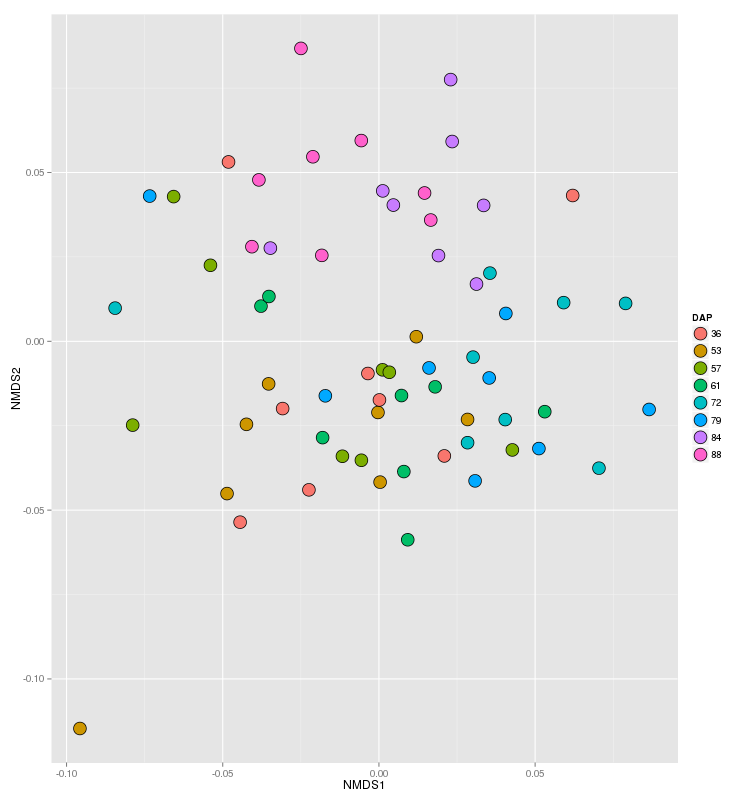

In [22]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), size = 6, pch=21) 

p1

In [25]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.wunif.dist
bareadonis = adonis(d ~ DAP + Library, df)
bareadonis


Call:
adonis(formula = d ~ DAP + Library, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP        7   0.10626 0.015180  2.7513 0.23605  0.001 ***
Library    1   0.04043 0.040434  7.3285 0.08982  0.001 ***
Residuals 55   0.30346 0.005517         0.67412           
Total     63   0.45015                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.bray.dist
bareadonis = adonis(d ~ Library + DAP + Rep, df)
bareadonis



Call:
adonis(formula = d ~ Library + DAP + Rep, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Library    1    0.3287 0.32867  5.7278 0.07951  0.001 ***
DAP        7    0.6014 0.08591  1.4972 0.14549  0.001 ***
Rep        1    0.1048 0.10482  1.8267 0.02536  0.002 ** 
Residuals 54    3.0986 0.05738         0.74964           
Total     63    4.1335                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Cluster analysis to determine if Mi-Seq Run is grouping

In [31]:
%%R
HC = hclust(bare.wunif.dist, method = "average", members = NULL)

$type
[1] "phylogram"

$use.edge.length
[1] TRUE

$node.pos
[1] 1

$node.depth
[1] 1

$show.tip.label
[1] TRUE

$show.node.label
[1] FALSE

$font
[1] 3

$cex
[1] 1

$adj
[1] 0

$srt
[1] 0

$no.margin
[1] FALSE

$label.offset
[1] 0

$x.lim
[1] 0.0000000 0.1236099

$y.lim
[1]  1 64

$direction
[1] "rightwards"

$tip.color
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

$Ntip
[1] 64

$Nnode
[1] 63

$root.time
NULL



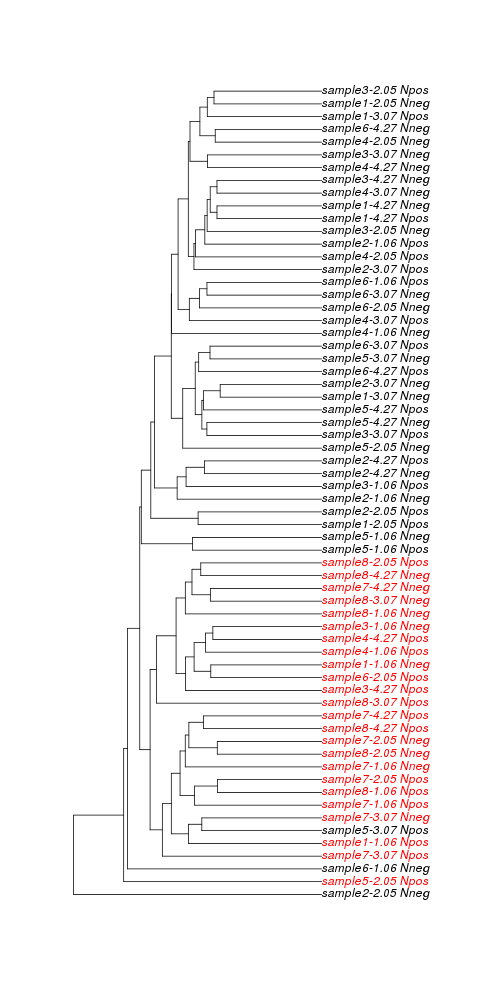

In [32]:
%%R -h 1000
library(ape)
Var = sample_data(bare)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
p = plot(result_phylo, tip.col = Var)
p

In [93]:
%%R
#pdf(file = "/home/bryan/RhizCG/figures/diagnostics/control_batch.pdf", width = 6.5, height = 9)
#p = plot(result_phylo, tip.col = Var)
#dev.off()

png 
  2 


In [70]:
%%R
colnames(sample_data(bare))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        


In [71]:
%%R
sample_data(bare)[,1:7]

Sample Data:        [64 samples by 7 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
sample5-3.07_Nneg sample5-3.07_Nneg       1            2             D9
sample6-3.07_Npos sample6-3.07_Npos       1            2            D11
sample3-3.07_Npos sample3-3.07_Npos       1            1            C11
sample1-4.27_Npos sample1-4.27_Npos       1            1             F9
sample4-3.07_Nneg sample4-3.07_Nneg       1            1            H11
sample6-1.06_Npos sample6-1.06_Npos       1            2            A11
sample4-

In [33]:
%%R
HC = hclust(bare.bray.dist, method = "average", members = NULL)

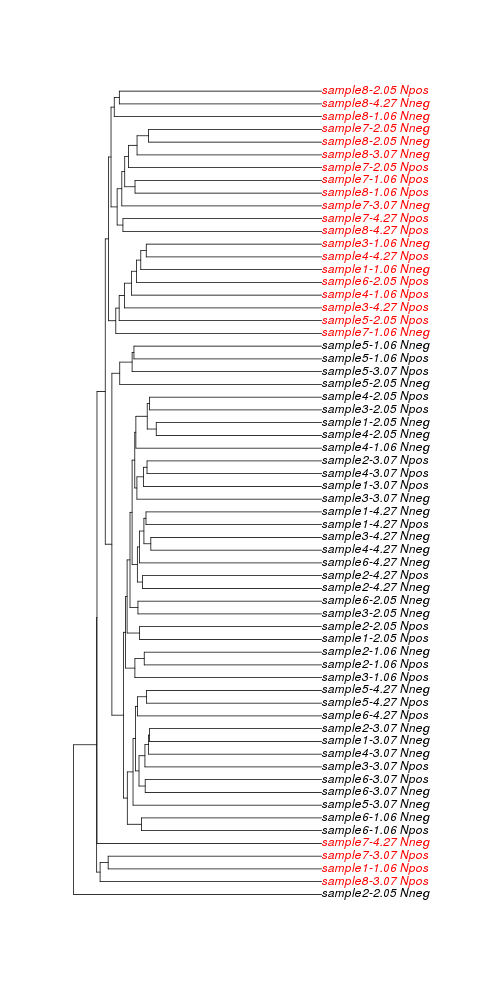

In [34]:
%%R -h 1000
library(ape)
Var = sample_data(bare)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
plot(result_phylo, tip.col = Var)

## Subset just plants to evaluate variation without bare soil

In [35]:
%%R

plant = subset_samples(physeq.snorm, Plant != "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)
plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1709 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 1709 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1709 tips and 1708 internal nodes ]


In [36]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [39]:
%%R -w 800 -h 350


nmds = ordinate(plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(plant, nmds, justDF = TRUE)

Run 0 stress 0.1766991 
Run 1 stress 0.187023 
Run 2 stress 0.1775762 
Run 3 stress 0.1905515 
Run 4 stress 0.1922317 
Run 5 stress 0.1767099 
... procrustes: rmse 0.001744935  max resid 0.0220197 
Run 6 stress 0.1769088 
... procrustes: rmse 0.02126643  max resid 0.2335845 
Run 7 stress 0.1862899 
Run 8 stress 0.17671 
... procrustes: rmse 0.001744807  max resid 0.02202196 
Run 9 stress 0.1856176 
Run 10 stress 0.2011522 
Run 11 stress 0.1746998 
... New best solution
... procrustes: rmse 0.01929403  max resid 0.2345139 
Run 12 stress 0.184516 
Run 13 stress 0.1975008 
Run 14 stress 0.1861161 
Run 15 stress 0.1802836 
Run 16 stress 0.1878693 
Run 17 stress 0.1826056 
Run 18 stress 0.1825005 
Run 19 stress 0.1922113 
Run 20 stress 0.177892 


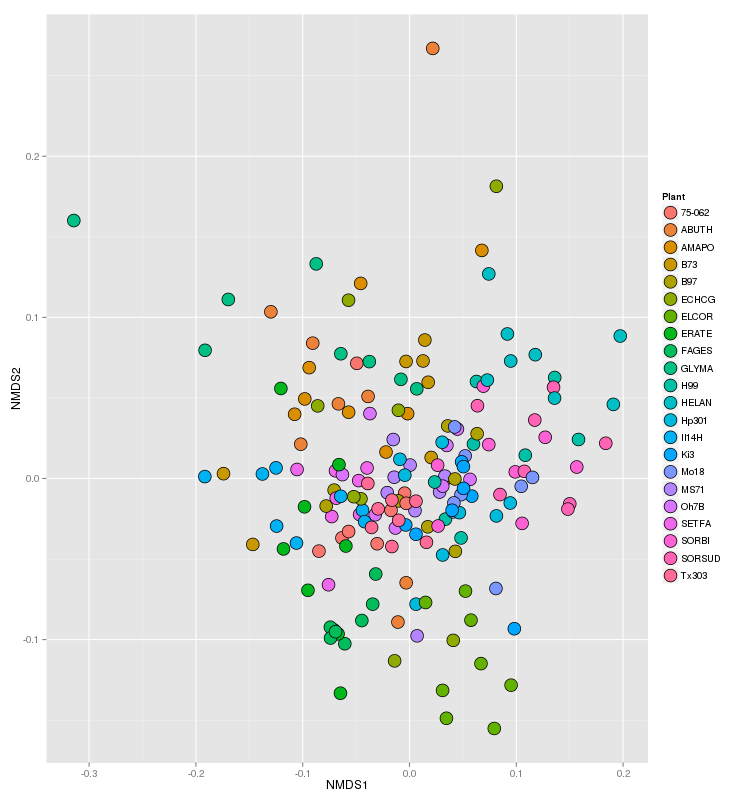

In [40]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

In [41]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = distance(plant, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [42]:
%%R
HC = hclust(plant.bray.dist, method = "average", members = NULL)

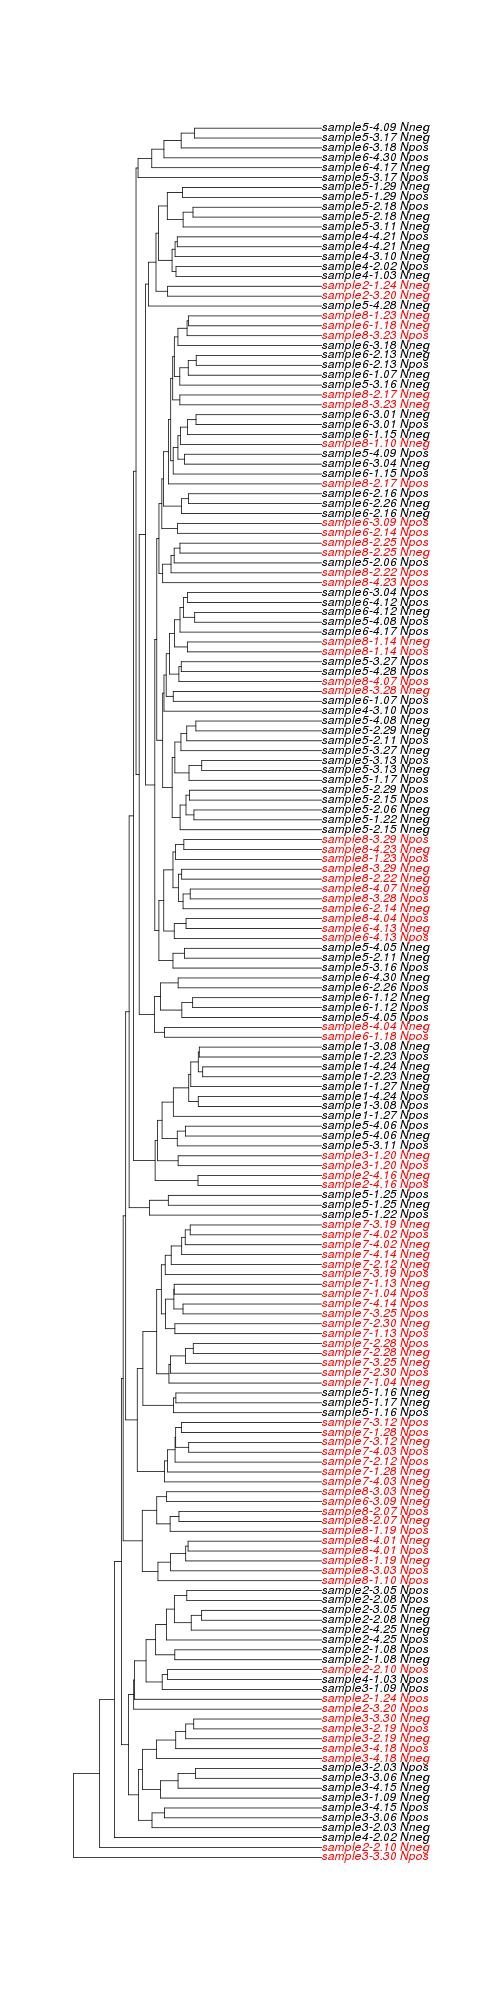

In [43]:
%%R -h 2000
library(ape)
Var = sample_data(plant)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
plot(result_phylo, tip.col = Var)

## Hypothesis Testing on Plant subset

In [46]:
%%R
df = as(sample_data(plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ Library + DAP + Plant, df)
plantadonis


Call:
adonis(formula = d ~ Library + DAP + Plant, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Library     1    0.4139 0.41390  26.542 0.08893  0.001 ***
DAP         1    0.2668 0.26681  17.110 0.05733  0.001 ***
Plant      19    1.5721 0.08274   5.306 0.33777  0.001 ***
Residuals 154    2.4015 0.01559         0.51597           
Total     175    4.6544                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [54]:
%%R
plant_group = get_variable(plant, "Plant")
d = wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5935 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0231 0.0308 0.0350 0.0404 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   2 4132.75 7935.5 11671.25 15400 14784
75-062   42  375.50 1026.0  3040.75  8062    28
ABUTH    66 2489.75 6486.5 12922.25 15128    28
AMAPO    16  938.50 2736.0  5022.25 13028    28
B73     107  876.00 3643.0  9604.00 12055    28
B97      34  903.25 1534.5  4489.75  8921    28
ECHCG    24 4880.00 8172.5 12648.25 14618    28
ELCOR    37  486.00 1685.5  3987.25 10575    28
ERATE    18  712.75 2074.5  5171.25 14206    28
FAGES     1   16.25   75.5   317.75  2169    28
GLYMA   497 4290.75 8761.0 11616.00 15076    28
H99      69 1149.50 2812.0  4430.50  6081    28
HELAN    78 1033.75 1727.0  2865.25  8425    28
Hp301  

## NMDS of unweighted-unifrac distances

In [33]:
%%R
registerDoParallel(cores=28)

uwunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1400851 
Run 1 stress 0.1456237 
Run 2 stress 0.1668139 
Run 3 stress 0.1554389 
Run 4 stress 0.1631645 
Run 5 stress 0.1562493 
Run 6 stress 0.1402482 
... procrustes: rmse 0.003617534  max resid 0.05179527 
Run 7 stress 0.1554036 
Run 8 stress 0.1520922 
Run 9 stress 0.1582269 
Run 10 stress 0.1644517 
Run 11 stress 0.140081 
... New best solution
... procrustes: rmse 0.000810312  max resid 0.006604266 
*** Solution reached


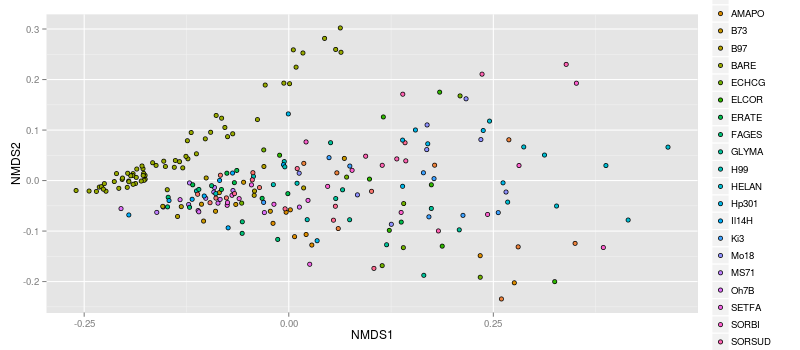

In [34]:
%%R -w 800 -h 350


nmds = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = uwunif.dist)

p = plot_ordination(physeq.snorm, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

#Heatmaps of taxon abundances



In [35]:
%%R
physeq.snorm %>% tax_table %>% head

Taxonomy Table:     [6 taxa by 8 taxonomic ranks]:
          Rank1      Rank2             Rank3          Rank4                   
OTU.5899  "Bacteria" "__Acidobacteria" "__32-21"      "__uncultured_bacterium"
OTU.11339 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.11867 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.12445 "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.8680  "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
OTU.2666  "Bacteria" "__Acidobacteria" "__Holophagae" "__Sva0725"             
          Rank5                    Rank6 Rank7 Rank8
OTU.5899  NA                       NA    NA    NA   
OTU.11339 "__uncultured_bacterium" NA    NA    NA   
OTU.11867 "__uncultured_bacterium" NA    NA    NA   
OTU.12445 NA                       NA    NA    NA   
OTU.8680  NA                       NA    NA    NA   
OTU.2666  "__uncultured_bacterium" NA    NA    NA   


In [36]:
%%R -w 800 
physeq.snorm.t50 <- prune_taxa(names(sort(taxa_sums(physeq.snorm),TRUE)[1:10]), physeq.snorm)

plot_heatmap(physeq.snorm.t50, sample.label='Plant', taxa.label='Rank2')

ggsave("heatmap_rank2.pdf")

Saving 11.1 x 6.67 in image


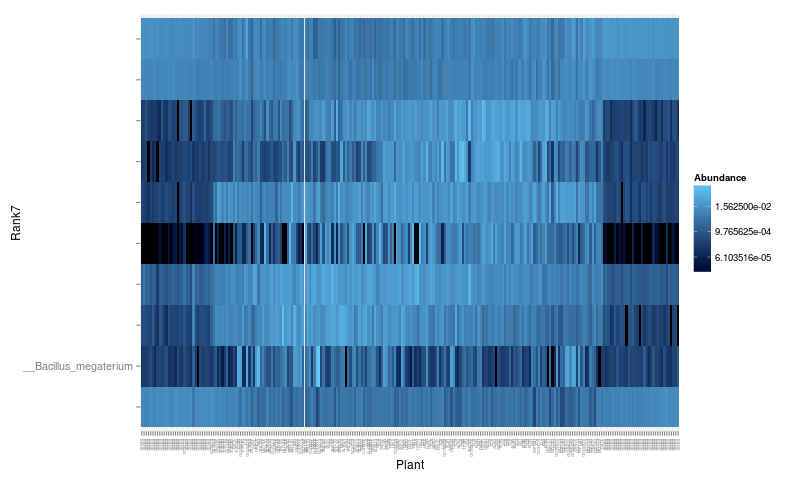

In [37]:
%%R -w 800 
physeq.snorm.t50 <- prune_taxa(names(sort(taxa_sums(physeq.snorm),TRUE)[1:10]), physeq.snorm)

plot_heatmap(physeq.snorm.t50, sample.label='Plant', taxa.label='Rank7')

##Analysis of changes in bare soil community over time

In [41]:
%%R
sample_names(physeq)

  [1] "sample2-1.06_Npos" "sample6-4.27_Npos" "sample4-4.27_Nneg"
  [4] "sample4-1.06_Nneg" "sample2-1.06_Nneg" "sample6-3.07_Nneg"
  [7] "sample5-3.07_Nneg" "sample6-3.07_Npos" "sample3-3.07_Npos"
 [10] "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample1-4.27_Npos"
 [13] "sample4-1.03_Npos" "sample5-2.06_Npos" "sample5-4.08_Npos"
 [16] "sample4-3.07_Nneg" "sample5-4.28_Npos" "sample6-1.06_Npos"
 [19] "sample4-2.05_Nneg" "sample2-4.27_Nneg" "sample1-2.05_Nneg"
 [22] "sample5-1.29_Npos" "sample5-4.27_Npos" "sample5-4.27_Nneg"
 [25] "sample1-3.07_Nneg" "sample4-2.02_Nneg" "sample4-4.21_Nneg"
 [28] "sample2-2.05_Nneg" "sample6-2.13_Npos" "sample5-2.29_Nneg"
 [31] "sample5-2.06_Nneg" "sample1-2.23_Nneg" "sample6-2.26_Nneg"
 [34] "sample6-3.18_Nneg" "sample5-3.13_Nneg" "sample2-2.08_Nneg"
 [37] "sample1-2.05_Npos" "sample3-2.05_Nneg" "sample5-1.17_Nneg"
 [40] "sample6-3.01_Npos" "sample3-2.03_Nneg" "sample5-4.08_Nneg"
 [43] "sample5-4.05_Npos" "sample5-1.06_Npos" "sample1-4.27_Nneg"
 [46] "sam